<h1>Загрузка и импорт библиотек</h1>

In [1]:
!pip install catboost
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool
import json
import re
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

<h1>Загрузка и анализ данных</h1>

In [3]:
train_df = pd.read_csv('/content/train_contest.csv')
test_df = pd.read_csv('/content/for_prediction.csv')

In [4]:
train_df.head(5)

,premium,name,department,has_test,response_letter_required,area,type,address,response_url,sort_point_distance,...,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url,mean_salary
0,False,Агент по недвижимости,NaN,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Невский...",NaN,NaN,...,[],[],False,"<p>Мы ищем людей, которым не достаточно того, ...","{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Жилая недвижимость'}, {'name': 'Акт...","[{'id': '20.20', 'name': 'Агент', 'profarea_id...",Санкт-Петербург,NaN,125000.0
1,False,IT-специалист/ техник,NaN,False,False,"{'id': '1130', 'name': 'Братск', 'url': 'https...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,...,[],[],False,<ul> </ul> <p><em><strong>Навыки</strong></em>...,"{'id': 'between1And3', 'name': 'От 1 года до 3...",[],"[{'id': '1.172', 'name': 'Начальный уровень, М...",Иркутская область,NaN,50000.0
2,False,Старший/ведущий инженер-программист,NaN,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': '60К-9, 1...",NaN,NaN,...,[],[],False,<strong>Обязанности:</strong> <ul> <li>Разрабо...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Linux'}, {'name': 'Bash'}, {'name':...","[{'id': '1.221', 'name': 'Программирование, Ра...",Ростовская область,NaN,80000.0
3,False,Эксперт / методист приемной комиссии,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': '1-я Миусская ули...",NaN,NaN,...,[],[],False,<p>Департамент информационных технологий РХТУ ...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': '1С программирование'}, {'name': 'Об...","[{'id': '3.150', 'name': 'Менеджмент продукта ...",Москва,NaN,120000.0
4,False,Табельщица/табельщик,NaN,False,False,"{'id': '1613', 'name': 'Энгельс', 'url': 'http...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",NaN,NaN,...,[],[],False,<p><strong>Обязанности:</strong></p> <ul> <li>...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Составление отчетности'}, {'name': ...","[{'id': '18.142', 'name': 'Машиностроение', 'p...",Саратовская область,NaN,15000.0


In [5]:
print("Статистика mean_salary:")
print(train_df['mean_salary'].describe())

Статистика mean_salary:
count    3.007200e+04
mean     9.772825e+04
std      1.046010e+05
min      2.000000e+01
25%      4.250000e+04
50%      7.000000e+04
75%      1.200000e+05
max      2.750000e+06
Name: mean_salary, dtype: float64


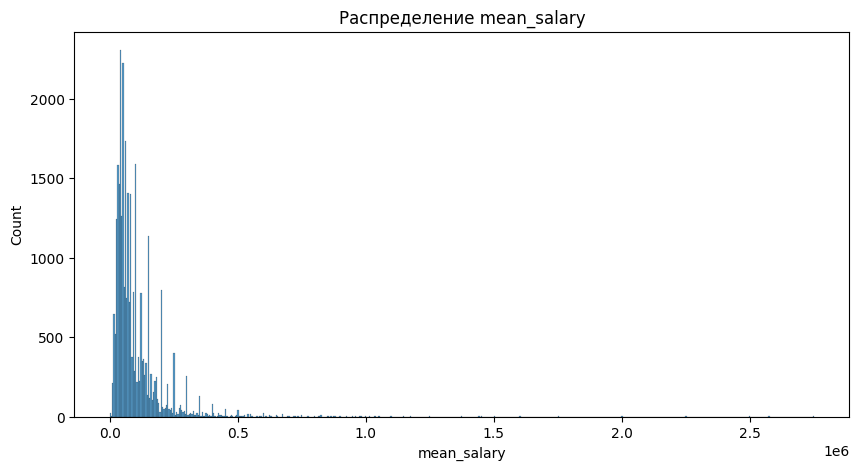

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['mean_salary'])
plt.title('Распределение mean_salary')
plt.show()

In [7]:
print("Проверка выбросов в mean_salary (train):")
low_salary_count = train_df[train_df['mean_salary'] < 10000].shape[0]
high_salary_count = train_df[train_df['mean_salary'] > 450000].shape[0]
print(f"Записей с mean_salary < 10,000: {low_salary_count}")
print(f"Записей с mean_salary > 450,000: {high_salary_count}")

Проверка выбросов в mean_salary (train):
Записей с mean_salary < 10,000: 30
Записей с mean_salary > 450,000: 296


<h1>Предварительная обработка данных</h1>

Удаление выбросов

In [8]:
q_low = train_df['mean_salary'].quantile(0.001) #удаление 0,1%
q_high = train_df['mean_salary'].quantile(0.99) #удаление 1%
train_df = train_df[(train_df['mean_salary'] >= q_low) & (train_df['mean_salary'] <= q_high)]
print(f"После удаления выбросов: {train_df.shape[0]} строк")

После удаления выбросов: 29746 строк


Обработка JSON, списков, признаков key_skills и experience

In [9]:
def json_field(x, key):
    try:
        if pd.isna(x):
            return 'Unknown'
        x = json.loads(x.replace("'", '"')) if isinstance(x, str) else x
        return x.get(key, 'Unknown')
    except:
        return 'Unknown'

In [10]:
def list_field(x):
    try:
        if pd.isna(x) or x == '[]':
            return 0
        x = json.loads(x.replace("'", '"')) if isinstance(x, str) else x
        return len(x)
    except:
        return 0

In [11]:
def skill(x, skill):
    try:
        if pd.isna(x) or x == '[]':
            return 0
        x = json.loads(x.replace("'", '"')) if isinstance(x, str) else x
        return 1 if any(skill.lower() in s['name'].lower() for s in x) else 0
    except:
        return 0

In [12]:
def experience(x):
    try:
        x = json_field(x, 'name')
        if 'Нет опыта' in x:
            return 0
        elif '1 года до 3' in x:
            return 2
        elif '3 до 6' in x:
            return 4.5
        elif 'Более 6' in x:
            return 6
        return 0
    except:
        return 0

Добавление столбцов

In [13]:
for df in [train_df, test_df]:
    df['area_name'] = df['area'].apply(lambda x: json_field(x, 'name'))
    df['address_street'] = df['address'].apply(lambda x: json_field(x, 'street'))

for df in [train_df, test_df]:
    df['key_skills_count'] = df['key_skills'].apply(list_field)
    df['specializations_count'] = df['specializations'].apply(list_field)

for df in [train_df, test_df]:
    df['has_python'] = df['key_skills'].apply(lambda x: skill(x, 'Python'))
    df['has_sql'] = df['key_skills'].apply(lambda x: skill(x, 'SQL'))
    df['has_management'] = df['key_skills'].apply(lambda x: skill(x, 'управление|management'))
    df['has_javascript'] = df['key_skills'].apply(lambda x: skill(x, 'JavaScript'))

for df in [train_df, test_df]:
    df['experience_years'] = df['experience'].apply(experience)

In [14]:
train_df.head(5)

,premium,name,department,has_test,response_letter_required,area,type,address,response_url,sort_point_distance,...,mean_salary,area_name,address_street,key_skills_count,specializations_count,has_python,has_sql,has_management,has_javascript,experience_years
0,False,Агент по недвижимости,NaN,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Невский...",NaN,NaN,...,125000.0,Санкт-Петербург,Unknown,6,5,0,0,0,0,0.0
1,False,IT-специалист/ техник,NaN,False,False,"{'id': '1130', 'name': 'Братск', 'url': 'https...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,...,50000.0,Братск,Unknown,0,5,0,0,0,0,2.0
2,False,Старший/ведущий инженер-программист,NaN,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': '60К-9, 1...",NaN,NaN,...,80000.0,Ростов-на-Дону,Unknown,3,5,0,0,0,0,2.0
3,False,Эксперт / методист приемной комиссии,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': '1-я Миусская ули...",NaN,NaN,...,120000.0,Москва,Unknown,5,2,0,1,0,0,2.0
4,False,Табельщица/табельщик,NaN,False,False,"{'id': '1613', 'name': 'Энгельс', 'url': 'http...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",NaN,NaN,...,15000.0,Энгельс,Unknown,7,1,0,0,0,0,2.0


Векторизация

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
for df in [train_df, test_df]:
    df['description'] = df['description'].fillna('')

tfidf = TfidfVectorizer(max_features=50, stop_words=['и', 'в', 'на', 'с', 'по'], ngram_range=(1, 2))
tfidf.fit(train_df['description'])
train_tfidf = pd.DataFrame(
    tfidf.transform(train_df['description']).toarray(),
    columns=[f'tfidf_{word}' for word in tfidf.get_feature_names_out()],
    index=train_df.index
)
test_tfidf = pd.DataFrame(
    tfidf.transform(test_df['description']).toarray(),
    columns=[f'tfidf_{word}' for word in tfidf.get_feature_names_out()],
    index=test_df.index
)
train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

Обработка признаков из description, name и удаленной работы

In [16]:
for df in [train_df, test_df]:
    df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    df['is_senior'] = df['description'].str.contains('senior|ведущий|старший', case=False, na=False).astype(int)
    df['is_junior'] = df['description'].str.contains('junior|младший|стажер', case=False, na=False).astype(int)
    df['is_lead'] = df['description'].str.contains('lead|руководитель|тимлид', case=False, na=False).astype(int)

In [17]:
for df in [train_df, test_df]:
    df['name_is_senior'] = df['name'].str.contains('senior|ведущий|старший', case=False, na=False).astype(int)
    df['name_is_junior'] = df['name'].str.contains('junior|младший|стажер', case=False, na=False).astype(int)
    df['name_is_middle'] = df['name'].str.contains('middle', case=False, na=False).astype(int)

In [18]:
for df in [train_df, test_df]:
    df['is_remote'] = df['schedule'].str.contains('remote|удал', case=False, na=False).astype(int)

Отображение department и дат

In [19]:
for df in [train_df, test_df]:
    df['is_department_missing'] = df['department'].isna().astype(int)

In [20]:
for df in [train_df, test_df]:
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'published_at' in col or 'created_at' in col]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[f'{col}_year'] = df[col].dt.year.fillna(0).astype(int)
        df[f'{col}_month'] = df[col].dt.month.fillna(0).astype(int)
        df[f'{col}_day'] = df[col].dt.day.fillna(0).astype(int)
        df = df.drop(columns=[col])

In [21]:
train_df.head(5)

,premium,name,department,has_test,response_letter_required,area,type,address,response_url,sort_point_distance,...,is_junior,is_lead,name_is_senior,name_is_junior,name_is_middle,is_remote,is_department_missing,published_at_year,published_at_month,published_at_day
0,False,Агент по недвижимости,NaN,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Невский...",NaN,NaN,...,0,0,0,0,0,0,1,2022,5,26
1,False,IT-специалист/ техник,NaN,False,False,"{'id': '1130', 'name': 'Братск', 'url': 'https...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,...,0,0,0,0,0,0,1,2022,5,19
2,False,Старший/ведущий инженер-программист,NaN,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': '60К-9, 1...",NaN,NaN,...,0,0,1,0,0,0,1,2022,5,25
3,False,Эксперт / методист приемной комиссии,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': '1-я Миусская ули...",NaN,NaN,...,0,0,0,0,0,0,1,2022,5,4
4,False,Табельщица/табельщик,NaN,False,False,"{'id': '1613', 'name': 'Энгельс', 'url': 'http...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",NaN,NaN,...,0,0,0,0,0,0,1,2022,5,23


Заполнение пропусков

In [22]:
categorical_cols = ['premium', 'has_test', 'response_letter_required', 'type', 'archived',
                   'accept_temporary', 'schedule', 'working_days', 'working_time_intervals', 'working_time_modes']

In [23]:
for df in [train_df, test_df]:
    for col in df.columns:
        if col != 'mean_salary':
            if col in categorical_cols:
                df[col] = df[col].astype(str).fillna('Unknown')
            elif df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
                df[col] = df[col].fillna(df[col].median() if df[col].notna().any() else 0)
            else:
                df[col] = df[col].astype(str).fillna('Unknown')

Проверка пересечения признаков

In [24]:
overlap_cols = ['is_senior', 'name_is_senior', 'is_junior', 'name_is_junior', 'is_lead', 'name_is_middle']

overlap_corr = train_df[overlap_cols].corr()
print("Корреляция между признаками:\n", overlap_corr)
for col1, col2 in [('is_senior', 'name_is_senior'), ('is_junior', 'name_is_junior')]:
    matches = (train_df[col1] == train_df[col2]).mean()
    print(f"Совпадение между {col1} и {col2}: {matches:.2%}")
drop_overlap_cols = ['is_senior', 'is_junior', 'is_lead']
for df in [train_df, test_df]:
    df = df.drop(columns=[col for col in drop_overlap_cols if col in df.columns])

print("Удалены избыточные столбцы:", drop_overlap_cols)

Корреляция между признаками:
                 is_senior  name_is_senior  is_junior  name_is_junior  \
is_senior        1.000000        0.193247   0.061455        0.011047   
name_is_senior   0.193247        1.000000  -0.028462       -0.048825   
is_junior        0.061455       -0.028462   1.000000        0.297997   
name_is_junior   0.011047       -0.048825   0.297997        1.000000   
is_lead          0.169977        0.023118   0.052947        0.002894   
name_is_middle   0.099726        0.105401   0.008776        0.015217   

                 is_lead  name_is_middle  
is_senior       0.169977        0.099726  
name_is_senior  0.023118        0.105401  
is_junior       0.052947        0.008776  
name_is_junior  0.002894        0.015217  
is_lead         1.000000        0.032060  
name_is_middle  0.032060        1.000000  
Совпадение между is_senior и name_is_senior: 91.66%
Совпадение между is_junior и name_is_junior: 96.19%
Удалены избыточные столбцы: ['is_senior', 'is_junior', 'is_l

Опредление категориальных столбцов

Кодирование категориальных признаков

In [25]:
high_cardinality_cols = ['name', 'area_name', 'region', 'employer']#, 'snippet']
encoder = TargetEncoder(cols=high_cardinality_cols)
train_df[high_cardinality_cols] = encoder.fit_transform(train_df[high_cardinality_cols], train_df['mean_salary'])
test_df[high_cardinality_cols] = encoder.transform(test_df[high_cardinality_cols])

Удаление сложных полей

In [26]:
drop_cols = ['area', 'address', 'key_skills', 'specializations', 'description', 'experience',
             'response_url', 'immediate_redirect_url', 'department', 'insider_interview', 'published_at', 'created_at', 'url', 'alternate_url', 'relations', 'contacts', 'address_street', 'snippet']
for df in [train_df, test_df]:
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])
print("Столбцы в train_df после удаления:", train_df.columns.tolist())
print("Удалены столбцы:", drop_cols)

Столбцы в train_df после удаления: ['premium', 'name', 'has_test', 'response_letter_required', 'type', 'sort_point_distance', 'archived', 'employer', 'schedule', 'working_days', 'working_time_intervals', 'working_time_modes', 'accept_temporary', 'region', 'mean_salary', 'area_name', 'key_skills_count', 'specializations_count', 'has_python', 'has_sql', 'has_management', 'has_javascript', 'experience_years', 'tfidf_00', 'tfidf_1с', 'tfidf_br', 'tfidf_em', 'tfidf_em strong', 'tfidf_li', 'tfidf_li li', 'tfidf_li ul', 'tfidf_li знание', 'tfidf_li опыт', 'tfidf_quot', 'tfidf_strong', 'tfidf_strong strong', 'tfidf_strong ul', 'tfidf_strong обязанности', 'tfidf_strong требования', 'tfidf_strong условия', 'tfidf_ul', 'tfidf_ul li', 'tfidf_ul strong', 'tfidf_будет', 'tfidf_возможность', 'tfidf_вы', 'tfidf_график', 'tfidf_для', 'tfidf_до', 'tfidf_за', 'tfidf_знание', 'tfidf_или', 'tfidf_компании', 'tfidf_мы', 'tfidf_не', 'tfidf_недвижимости', 'tfidf_обучение', 'tfidf_обязанности', 'tfidf_обязанно

In [27]:
train_df.head()

,premium,name,has_test,response_letter_required,type,sort_point_distance,archived,employer,schedule,working_days,...,is_junior,is_lead,name_is_senior,name_is_junior,name_is_middle,is_remote,is_department_missing,published_at_year,published_at_month,published_at_day
0,False,124422.145329,False,False,"{'id': 'open', 'name': 'Открытая'}",0.0,False,92306.850907,"{'id': 'flexible', 'name': 'Гибкий график'}",[],...,0,0,0,0,0,0,1,2022,5,26
1,False,85932.995138,False,False,"{'id': 'open', 'name': 'Открытая'}",0.0,False,83897.109945,"{'id': 'flyInFlyOut', 'name': 'Вахтовый метод'}",[],...,0,0,0,0,0,0,1,2022,5,19
2,False,89836.249369,False,False,"{'id': 'open', 'name': 'Открытая'}",0.0,False,87115.136301,"{'id': 'fullDay', 'name': 'Полный день'}",[],...,0,0,1,0,0,0,1,2022,5,25
3,False,95040.588344,False,False,"{'id': 'open', 'name': 'Открытая'}",0.0,False,93258.038807,"{'id': 'fullDay', 'name': 'Полный день'}",[],...,0,0,0,0,0,0,1,2022,5,4
4,False,81379.198536,False,False,"{'id': 'open', 'name': 'Открытая'}",0.0,False,79854.046623,"{'id': 'fullDay', 'name': 'Полный день'}",[],...,0,0,0,0,0,0,1,2022,5,23


Фильтрация полей для модели CatBoostRegressor

In [28]:
categorical_cols = [col for col in categorical_cols if col in train_df.columns]
print("Категориальные столбцы для CatBoost:", categorical_cols)

Категориальные столбцы для CatBoost: ['premium', 'has_test', 'response_letter_required', 'type', 'archived', 'accept_temporary', 'schedule', 'working_days', 'working_time_intervals', 'working_time_modes']


 Разделение на X, y для train_df

In [29]:
X = train_df.drop(['mean_salary'], axis=1)
y = train_df['mean_salary']
print("Размер X:", X.shape)
print("Размер y:", y.shape)

y_log = np.log1p(y) # Логарифмирование целевой переменной

Размер X: (29746, 84)
Размер y: (29746,)


Разделение на обучающую и валидационную выборки

In [38]:
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")  #Для оценки модели перед предсказанием

X_train: (23796, 84), X_val: (5950, 84)


Подготовка тестовой выборки

In [39]:
test_ids = test_df['Id']
X_test = test_df.drop(columns=['Id'], errors='ignore')
X_test = X_test[X.columns]
print(f"X_test: {X_test.shape}")

X_test: (7518, 84)


<h1>Обучение модели CatBoostRegressor</h1>


In [40]:
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, l2_leaf_reg=10,
                         cat_features=categorical_cols, eval_metric='MAE', random_seed=42, verbose=100)

train_pool = Pool(X_train, y_train_log, cat_features=categorical_cols)
val_pool = Pool(X_val, y_val_log, cat_features=categorical_cols)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5314261	test: 0.5263703	best: 0.5263703 (0)	total: 59.7ms	remaining: 59.7s
100:	learn: 0.1623226	test: 0.1600281	best: 0.1600281 (100)	total: 3.44s	remaining: 30.6s
200:	learn: 0.1481863	test: 0.1495536	best: 0.1495536 (200)	total: 8.07s	remaining: 32.1s
300:	learn: 0.1406281	test: 0.1454956	best: 0.1454956 (300)	total: 11.2s	remaining: 25.9s
400:	learn: 0.1345495	test: 0.1427851	best: 0.1427851 (400)	total: 14.4s	remaining: 21.4s
500:	learn: 0.1294671	test: 0.1406552	best: 0.1406505 (497)	total: 18.6s	remaining: 18.6s
600:	learn: 0.1249934	test: 0.1392141	best: 0.1392141 (600)	total: 22.8s	remaining: 15.2s
700:	learn: 0.1209160	test: 0.1378345	best: 0.1378345 (700)	total: 26.2s	remaining: 11.2s
800:	learn: 0.1172949	test: 0.1369554	best: 0.1369554 (800)	total: 29.7s	remaining: 7.37s
900:	learn: 0.1142515	test: 0.1360194	best: 0.1360032 (899)	total: 34.6s	remaining: 3.8s
999:	learn: 0.1112422	test: 0.1354337	best: 0.1354337 (999)	total: 37.9s	remaining: 0us

bestTest = 0.13

Оценка на валидационной выборке

In [41]:
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val = np.expm1(y_val_log)
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE на валидации: {mae}")
print(f"MAE на обучении: {mean_absolute_error(np.expm1(model.predict(X_train)), np.expm1(y_train_log))}")

MAE на валидации: 12475.941893432742
MAE на обучении: 10207.060130630096


Визуализация

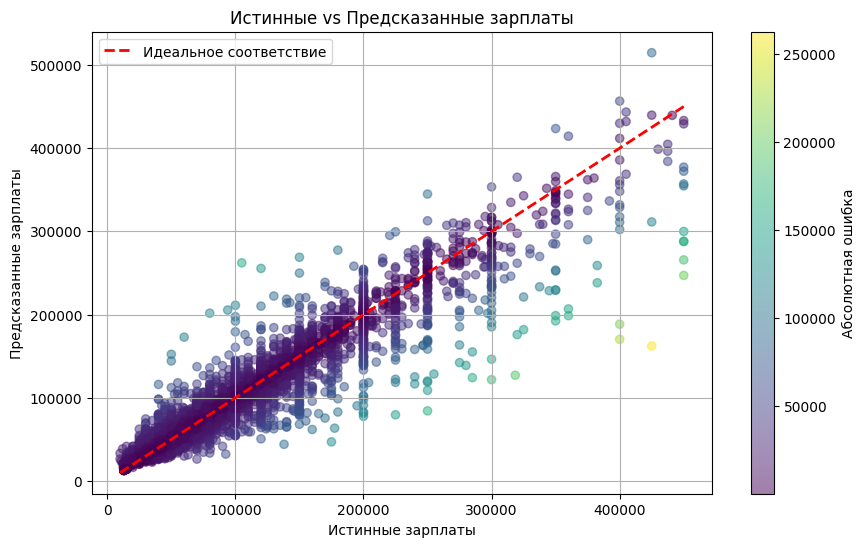

In [42]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(y_val, y_pred, c=np.abs(y_val - y_pred), cmap='viridis', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Идеальное соответствие')
plt.colorbar(scatter, label='Абсолютная ошибка')
plt.xlabel('Истинные зарплаты')
plt.ylabel('Предсказанные зарплаты')
plt.title('Истинные vs Предсказанные зарплаты')
plt.legend()
plt.grid(True)
plt.show()

Оценка важности признаков

In [43]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
}).sort_values(by='importance', ascending=False)
print("Топ-10 признаков:")
print(feature_importance.head(10))

Топ-10 признаков:
               feature  importance
7             employer   35.562593
1                 name   35.145857
21    experience_years    3.649471
14           area_name    2.775676
13              region    1.595974
72  description_length    0.772828
51      tfidf_компании    0.738871
54  tfidf_недвижимости    0.737849
58          tfidf_опыт    0.722290
50           tfidf_или    0.696331


Предсказание для тестовой выборки

In [44]:
test_pool = Pool(X_test, cat_features=categorical_cols)
y_test_pred_log = model.predict(test_pool)
y_test_pred = np.expm1(y_test_pred_log)

Сохранение результатов

In [45]:
submission = pd.DataFrame({'Id': test_ids, 'Predicted': y_test_pred})
submission.to_csv('submission.csv', index=False) #Сабмит сохранен: submission.csv
model.save_model('catboost_model.cbm') #Модель сохранена: catboost_model.cbm

Разработанная модель CatBoostRegressor демонстрирует высокую точность в задаче предсказания средних зарплат на основе данных о вакансиях. С использованием 1000 итераций, глубины дерева 6 и коэффициента регуляризации 10 модель достигла средней абсолютной ошибки (MAE) на валидационной выборке 12,475 рублей, что означает среднее отклонение предсказанных зарплат от истинных на 12,475 рублей. Это сильный результат для диапазона зарплат от 10,000 до 450,000 рублей (среднее ~91,307 рублей). На обучающей выборке MAE составила 10,207 рублей, что подтверждает хорошую обобщающую способность модели с умеренным уровнем переобучения.

Ключевую роль в точности предсказаний сыграли текстовые признаки, извлеченные из описаний вакансий с помощью TF-IDF (50 признаков), а также закодированные категориальные и высококардинальные признаки, включая название вакансии, регион, работодателя и географическую локацию. Дополнительные признаки, такие как опыт работы, наличие удаленной работы, количество ключевых навыков и длина описания вакансии, усилили способность модели улавливать вариации в зарплатах.

Предсказания для тестового набора данных сохранены в файл submission.csv, а обученная модель — в файл catboost_model.cbm.